# CSCK507 Mid Module - Toxic Comment Classification Challenge

## Table of Contents
[Section 1. Introduction](#introduction)
- [Import Dependencies](#import-dependencies)
- [Loading Kaggle dataset into DataFrame](#import-dependencies)
- [Initialise SpaCy Model ](#import-dependencies)

[Section 2. Data Exploration & Analysis](#data-exploration-&-analysis)
- [2.1 Data Preparation and Preprocessing](#data-exploration-&-analysis)
    - [2.1.1 Dataset Alignment](#data-preprocessing)
    - [2.1.2 Text Cleaning and Formatting](#data-preprocessing)
    - [2.1.3 Tokenisation & Lemmatisation](#data-preprocessing)
    - [2.1.4 Combining Tokenised Data and Labels for Training and Test Dataset](#data-preprocessing)
- [2.2 Data Analysis Requirements](#data-exploration-&-analysis)
    - [2.2.1 Number of Sentences & Tokens Per Class](#data-preprocessing)
    - [2.2.2 Data Imbalance](#data-imbalance)
    - [2.2.3 Understanding the Most Common Words](#data-preprocessing)
    - [2.2.4 Data Analysis Summary](#data-imbalance)
    
[Section 3. Machine Learning Model Development](#data-exploration-&-analysis)
- [3.1 Feature Extraction Methods](#data-preprocessing)
    - [3.1.1 TF-IDF Implementation](#data-preprocessing)
    - [3.1.2 Word Embedding](#data-preprocessing)
- [3.2 Model Selection & Training](#data-exploration-&-analysis)
    - [3.2.1 Logistic Regression](#data-preprocessing)
    - [3.2.2 Multinomial Naive Bayes](#data-preprocessing)
    - [3.2.3 Multi-LayerPerceptron](#data-preprocessing)


[Section 4. Evaluation of Selected Models](#data-exploration-&-analysis)
- [4.1 Feature Extraction Methods](#data-preprocessing)



---
## Section 1. Introduction

Originating in 2018, this challenge revolves around classifying different levels of toxicity in online comments. The dataset from the inaugural competition is utilized to analyze and evaluate the performance of various machine learning algorithms in categorizing six types of toxicity. The primary goal is not only to find an optimal solution but to understand the process of evaluating machine learning algorithms' performance in a classification task. This individual assessment involves data analysis, algorithm selection, and the exploration of feature extraction methods to uncover insights into the nuances of toxic comment classification.

The Toxic Comment Classification Challenge and dataset can be obtained here: [Kaggle Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data)

### Importing Dependencies

In [114]:
# General
import pandas as pd 
import numpy as np
import warnings
import os

# For Data Preprocessing
from nltk.corpus import stopwords
import nltk
import re  

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For Feature Extraction  
import dill
import spacy
import string 
from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.models import Word2Vec
from sklearn.base import TransformerMixin
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

# For Machine Learning
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 
# import eli5

### Load Kaggle dataset into DataFrame

In [115]:
df = pd.read_csv('dataset/train.csv')
df_test_labels = pd.read_csv('dataset/test_labels.csv')
df_test_comment = pd.read_csv('dataset/test.csv')

### Initialise SpaCy Model 

In [116]:
try:
    spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm')
except (LookupError, OSError):
    print('Run: python -m spacy download en_core_web_sm')

try:
    nltk_stop = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk_stop = stopwords.words('english')

---
## Section 2. Data Exploration & Analysis

In [117]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [118]:
df.info()
print("The table dimensions are:",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
The table dimensions are: (159571, 8)


### Aligning Train and Test Datasets

In [119]:
try:
    class_labels = list(df.columns[2:])
    print("Class labels extracted successfully.")

    # Remove rows with -1 from 'df_test' since they are not used for scoring
    print(f'df_test before removing -1: {df_test_labels.shape}')
    for class_label in class_labels:
        df_test_labels = df_test_labels[df_test_labels[class_label] != -1]

    print(f'df_test after removing -1: {df_test_labels.shape}')

    # Left join 'df_test' and 'df_test_comment' on the 'id' column
    df_test = pd.merge(df_test_labels, df_test_comment, on='id', how='left')
    print(f"Dataframes merged successfully.")

    # Create a new DataFrame called df_test and match the column structure of 'df'
    df_test = df_test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
    print("New DataFrame 'df_test' created successfully.")

except KeyError as ke:
    print(f"Error: {ke} not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Class labels extracted successfully.
df_test before removing -1: (153164, 7)
df_test after removing -1: (63978, 7)
Dataframes merged successfully.
New DataFrame 'df_test' created successfully.


### Data Preprocessing

In [120]:
def preprocess_text(text, nltk_stop=None):
    try:
        if nltk_stop is None:
            nltk_stop = set(stopwords.words('english'))
    except LookupError:
        print("NLTK stopwords not available. Consider downloading with nltk.download('stopwords').")

    try:
        # Combine URL removal, extra space replacement, and Non-English characters removal
        text = re.sub(r"(http\S+|www\S+|https\S+)|[^\x00-\x7F]+", " ", text)
        # Remove start and end white spaces
        text = text.strip()
        # Remove leading and trailing spaces and quotation marks
        text = text.strip('"')
        # Remove single characters
        text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
        # Remove punctuations and convert to lowercase
        text = re.sub(r"[^a-zA-Z0-9]+", " ", text).lower()
        # Stopword Removal using set operations
        text = ' '.join(set(text.split()) - nltk_stop)

        return text

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

The 'preprocess_text' function cleanses and standardises textual data for manageability purposes. 

It removes distracting elements like URLs, special characters, and numbers, ensuring a focused text corpus. Handling issues such as extra spaces, newline characters, and non-English characters guarantees consistent text structure. 

The function simplifies vocabulary by removing single characters and punctuation, while converting text to lowercase aids in case-insensitive consistency. 

The final step involves removing common stopwords, refining the text for meaningful content. 

### Tokenisation and Lemmatisation

In [121]:
def tokenize_lemma_text(documents):
    """
    Tokenize a list of documents and perform the following:
    1. Break text into individual words or subword tokens.
    2. Reduce words to their base or root form using lemmatization.
    3. Remove stop words and non-alphabetic characters.

    Utilises spaCy's nlp.pipe for efficient batch processing.

    :param documents: List of strings representing documents.
    :return: List of lists of strings, where each list corresponds to the lemmatized tokens of a document.
    """
    lemmatized_tokens_list = []
    
    # Process documents using spaCy's nlp.pipe with 'NER' and 'Parser' components disabled utilising 4 core parallel processing:
    for doc in nlp.pipe(documents, disable=["ner", "parser"], batch_size=5000, n_process=4):
        # Generate lemmatised tokens, remove stop words, and non-alphabetic characters
        lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        lemmatized_tokens_list.append(lemmatized_tokens)

    return lemmatized_tokens_list

In many tokenisation tasks, especially when primarily interested in lemmatisation and removing stop words, additional information provided by the 'NER' and 'Parser' components are not required. 

Disabling these components during the processing of documents with nlp.pipe will reduce computational loadd and can significantly improve efficiency and speed. This is especially critical when dealing with large amounts of text data. Although it comes as a trade-off between computational resources and specific linguistic information for the required task.

In [122]:
# Preprocess the train dataset
df['comment_text'] = df['comment_text'].apply(preprocess_text)
print("Preprocessed train dataset:")

#Display random rows from the training set
random_rows_train = df.sample(n=10) 
display(random_rows_train)

Preprocessed train dataset:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
32264,55c6632514a8ffa9,goes key low got sort vandalize bullshit edit ...,1,0,1,0,0,0
99765,15d902be49fc2f7c,modify wp wikipedia useful image proposed prop...,0,0,0,0,0,0
8019,155f0d1a3641c408,know nearly online kind real life nice poser,0,0,0,0,0,0
144889,14118adf2b668d31,jpgsuck image scrotum balls,1,0,1,0,0,0
96020,018f3c34489141ac,lots shared mind ip shitheads us,1,0,1,0,0,0
63816,aac3149d9bc11d81,newsletter link notification future change wik...,0,0,0,0,0,0
96677,051592a30ce6f62b,dihck nihgga suck,1,1,1,0,1,1
49037,831a493bd51cdcf4,accepted already look term covered incident ar...,0,0,0,0,0,0
138764,e681fffd218cd4dc,already well helping article editors clarity c...,0,0,0,0,0,0
103906,2bf0458973686606,mk2 trivia screenshots article added provide a...,0,0,0,0,0,0


In [123]:
# Preprocess the test dataset
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)
print("\nPreprocessed test dataset:")


Preprocessed test dataset:


In [124]:
# Tokenizing the train and test datasets
tokenized_comment_train = tokenize_lemma_text(df['comment_text'].tolist())
tokenized_comment_test = tokenize_lemma_text(df_test['comment_text'].tolist())

# Get labels for train and test data
y = df[class_labels]
y_test = df_test[class_labels]

python(35726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35728) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35729) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Combining Tokenised Text and Labels for Training and Test Dataset

In [125]:
# For training data
df_train = pd.DataFrame({
    'comment_text': tokenized_comment_train,    # Tokenized comment text
    'toxic': y['toxic'],                        # Toxicity label
    'severe_toxic': y['severe_toxic'],          # Severe toxicity label
    'obscene': y['obscene'],                    # Obscenity label
    'threat': y['threat'],                      # Threatening language label
    'insult': y['insult'],                      # Insult label
    'identity_hate': y['identity_hate']         # Identity hate label
})

display(df_train.head())
print("The train dataset dimensions are:",df.shape)

# For test data
df_test = pd.DataFrame({
    'comment_text': tokenized_comment_test,     # Tokenized comment text for testing
    'toxic': y_test['toxic'],                   # Toxicity label for testing
    'severe_toxic': y_test['severe_toxic'],     # Severe toxicity label for testing
    'obscene': y_test['obscene'],               # Obscenity label for testing
    'threat': y_test['threat'],                 # Threatening language label for testing
    'insult': y_test['insult'],                 # Insult label for testing
    'identity_hate': y_test['identity_hate']    # Identity hate label for testing
})

display(df_test.head())
print("The test dataset dimensions are:",df_test.shape)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[edit, revert, hardcore, york, vandalisms, gas...",0,0,0,0,0,0
1,"[colour, utc, seemingly, stick, january, aww, ...",0,0,0,0,0,0
2,"[edit, instead, format, hey, constantly, talk,...",0,0,0,0,0,0
3,"[exact, statistic, accident, think, wikipedia,...",0,0,0,0,0,0
4,"[hero, page, remember, chance, sir]",0,0,0,0,0,0


The train dataset dimensions are: (159571, 8)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[think, discussion, understand, revert, highly...",0,0,0,0,0,0
1,"[horrible, god, dear, site]",0,0,0,0,0,0
2,"[samuel, bring, invariably, article, oz, way, ...",0,0,0,0,0,0
3,"[state, york, college, institution, suny, cent...",0,0,0,0,0,0
4,"[wikipedia, entry, possibility, sure, article,...",0,0,0,0,0,0


The test dataset dimensions are: (63978, 7)


### 2.1 Task 1 Requirements

**Number of Sentences and Tokens**
- Analyze the number of sentences and tokens per class.
- Check if the dataset is unbalanced or not.

**Most Common Words Analysis**
- Examine the most common words for each class.
- Understand the most used terms for each level of toxicity.

### Counting Number of Sentences & Tokens Per Class

In [126]:
# Create a dictionary list to store counts
class_counts = {'class_label': [], 'num_sentences': [], 'num_tokens': []}

for class_label in class_labels:
    # Select tokenised comments for the current class
    class_comments = df_train[df_train[class_label] == 1]['comment_text'].tolist()

    # Initialise counters
    total_sentences = 0
    total_tokens = 0

    # Iterate through tokenised comments in the current class
    for comment in class_comments:
        # Count sentences and tokens for each comment
        total_sentences += len(comment)
        total_tokens += sum(len(sentence) for sentence in comment)

    # Update the counts in the dictionary
    class_counts['class_label'].append(class_label)
    class_counts['num_sentences'].append(total_sentences)
    class_counts['num_tokens'].append(total_tokens)

# Create a DataFrame from the dictionary
class_counts_df = pd.DataFrame(class_counts)

# Display the result
print(class_counts_df)

     class_label  num_sentences  num_tokens
0          toxic         232869     1345894
1   severe_toxic          18057      100733
2        obscene         120420      677485
3         threat           6522       33736
4         insult         109743      620310
5  identity_hate          20909      124503


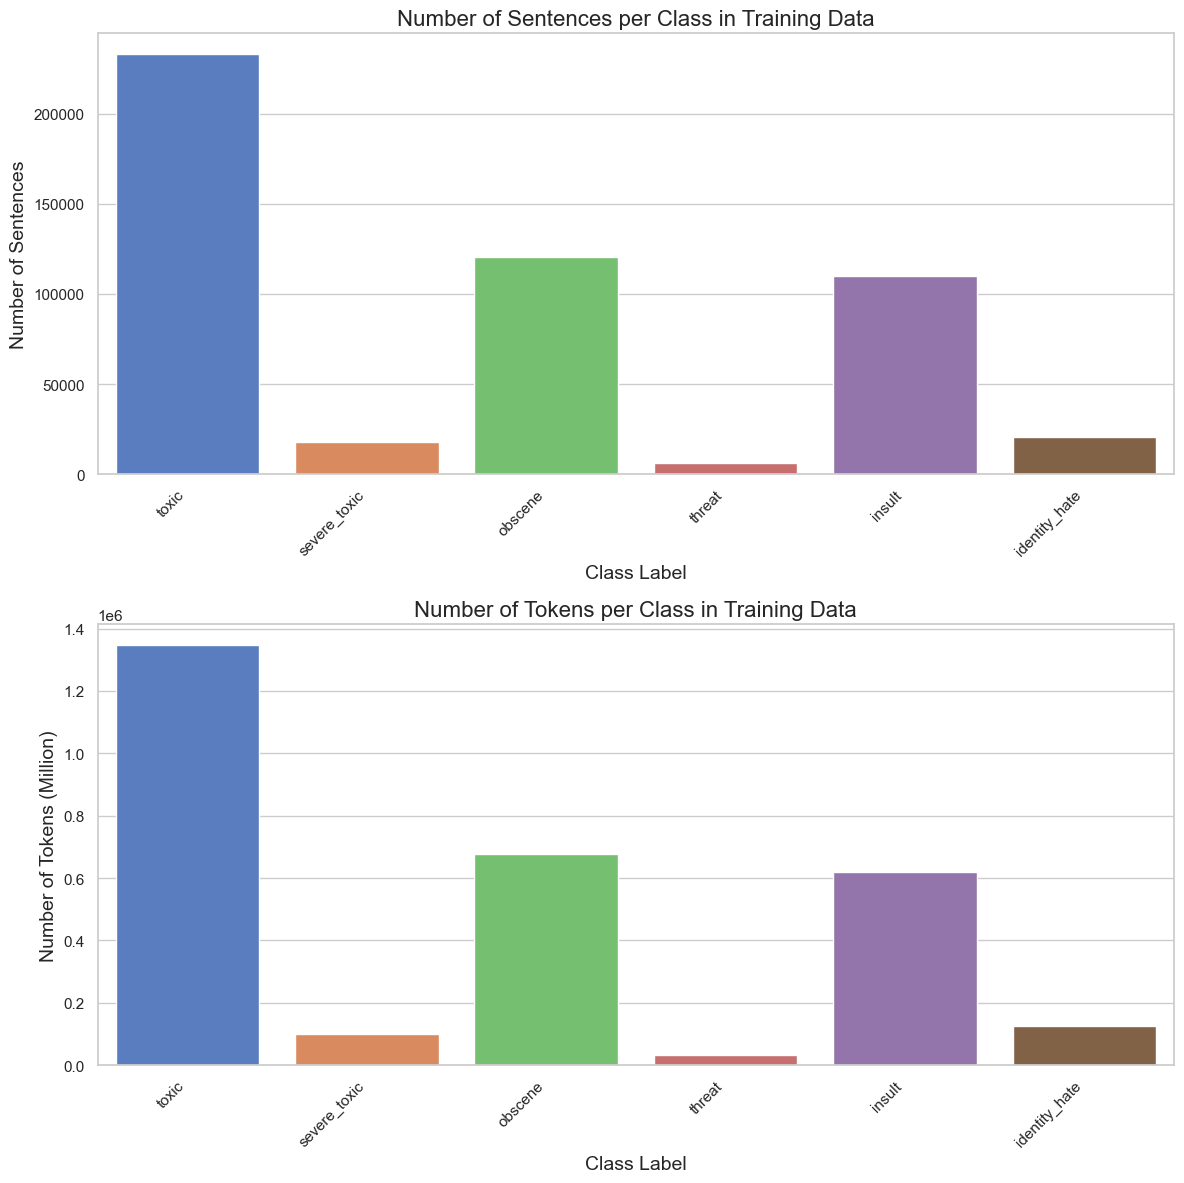

In [127]:
# Set the style for the plot
sns.set(style="whitegrid")

# Plot the number of sentences and tokens per class
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the number of sentences per class
sentences_plot = sns.barplot(ax=axes[0], x='class_label', y='num_sentences', data=class_counts_df, palette="muted")
sentences_plot.set_title('Number of Sentences per Class in Training Data', fontsize=16)
sentences_plot.set_xlabel('Class Label', fontsize=14)
sentences_plot.set_ylabel('Number of Sentences', fontsize=14)
sentences_plot.set_xticklabels(sentences_plot.get_xticklabels(), rotation=45, ha='right') 

# Plot the number of tokens per class
tokens_plot = sns.barplot(ax=axes[1], x='class_label', y='num_tokens', data=class_counts_df, palette="muted")
tokens_plot.set_title('Number of Tokens per Class in Training Data', fontsize=16)
tokens_plot.set_xlabel('Class Label', fontsize=14)
tokens_plot.set_ylabel('Number of Tokens (Million)', fontsize=14)
tokens_plot.set_xticklabels(tokens_plot.get_xticklabels(), rotation=45, ha='right')  

plt.tight_layout() 
plt.show()
warnings.filterwarnings(action = 'ignore')

### Understanding the Most Common Words in Training Data

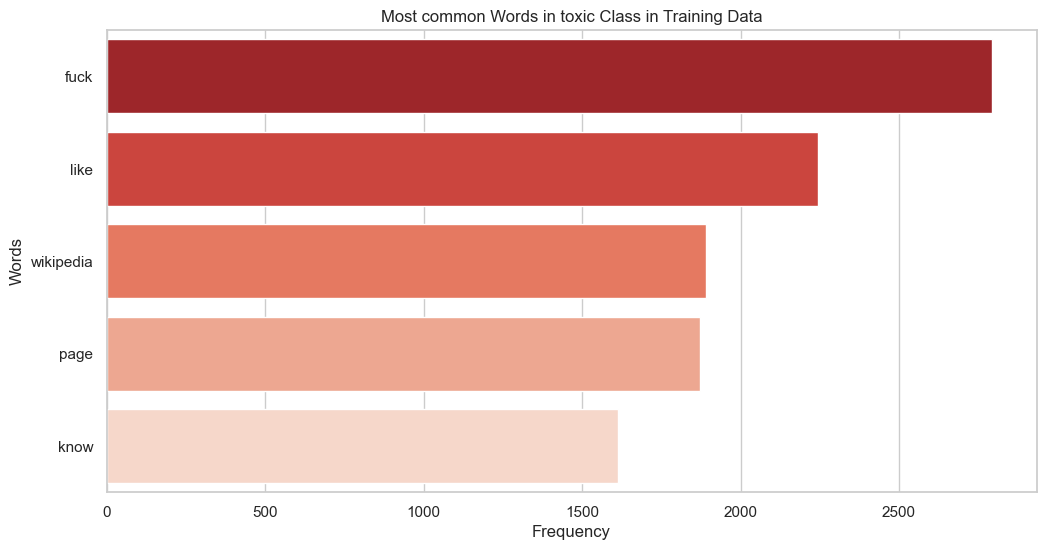

Most common words in toxic class: [('fuck', 2794), ('like', 2243), ('wikipedia', 1891), ('page', 1871), ('know', 1612)]


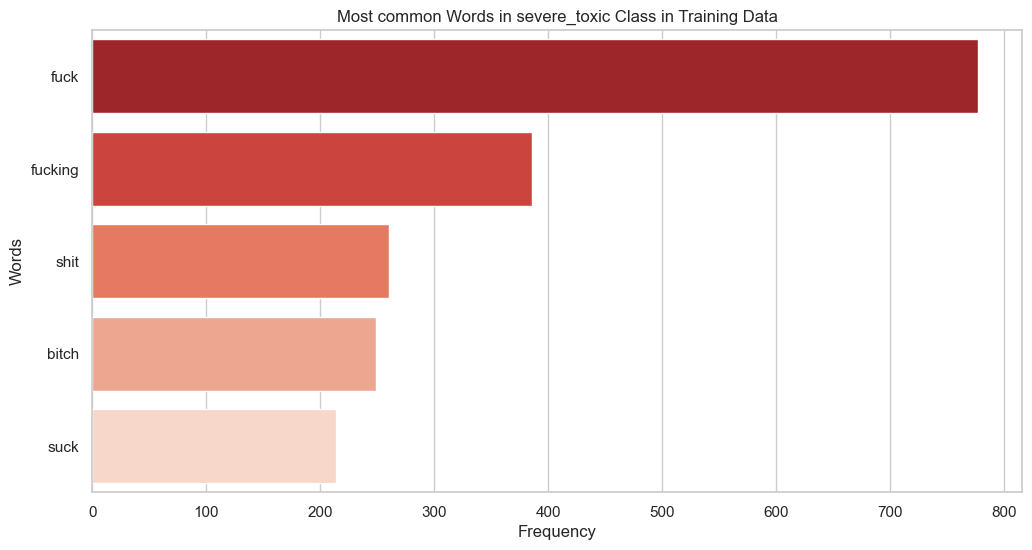

Most common words in severe_toxic class: [('fuck', 777), ('fucking', 386), ('shit', 260), ('bitch', 249), ('suck', 214)]


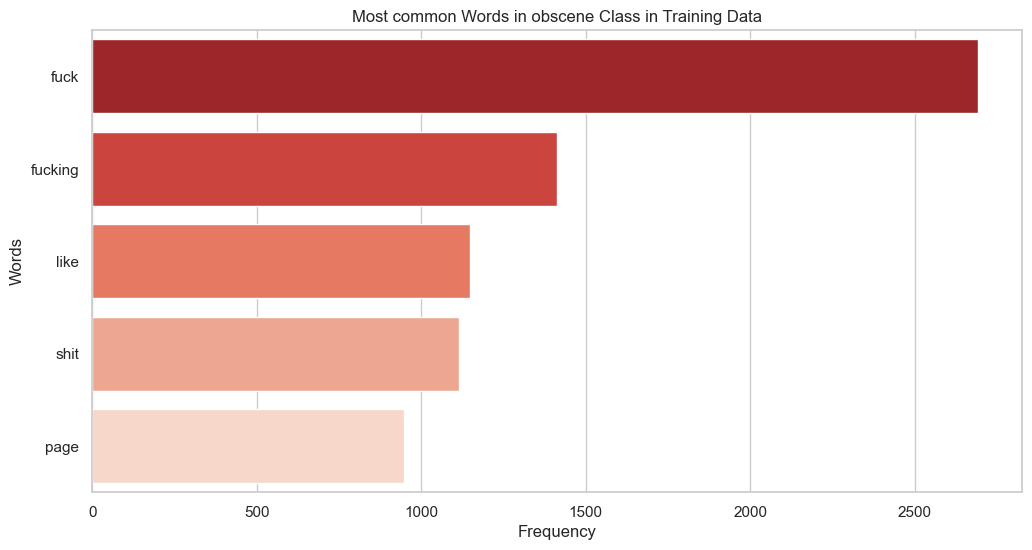

Most common words in obscene class: [('fuck', 2693), ('fucking', 1413), ('like', 1148), ('shit', 1116), ('page', 949)]


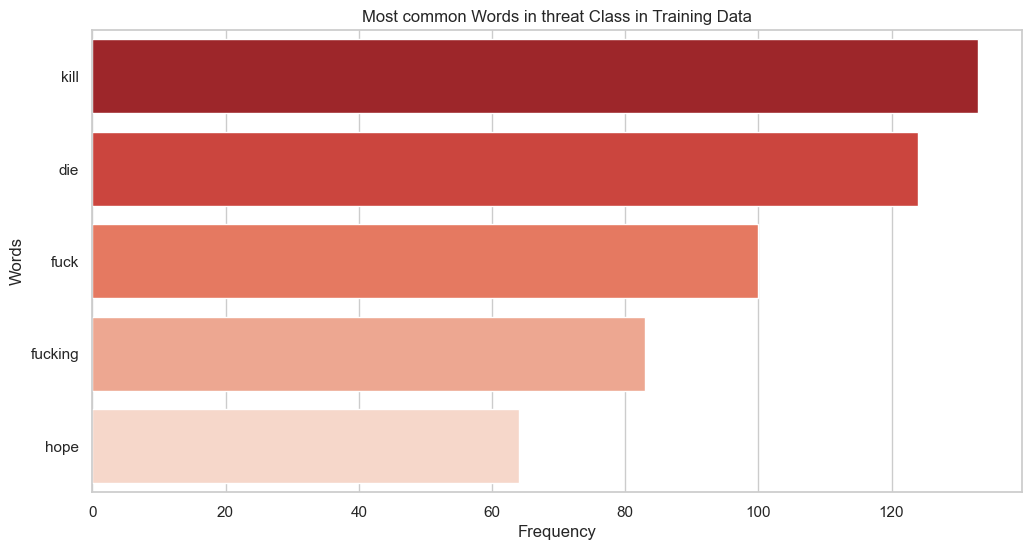

Most common words in threat class: [('kill', 133), ('die', 124), ('fuck', 100), ('fucking', 83), ('hope', 64)]


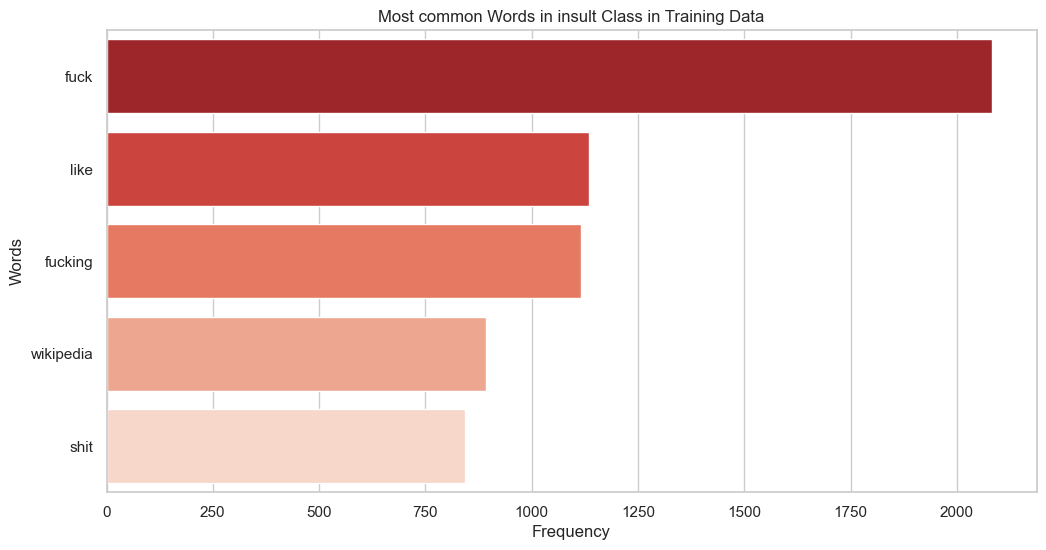

Most common words in insult class: [('fuck', 2083), ('like', 1135), ('fucking', 1117), ('wikipedia', 893), ('shit', 844)]


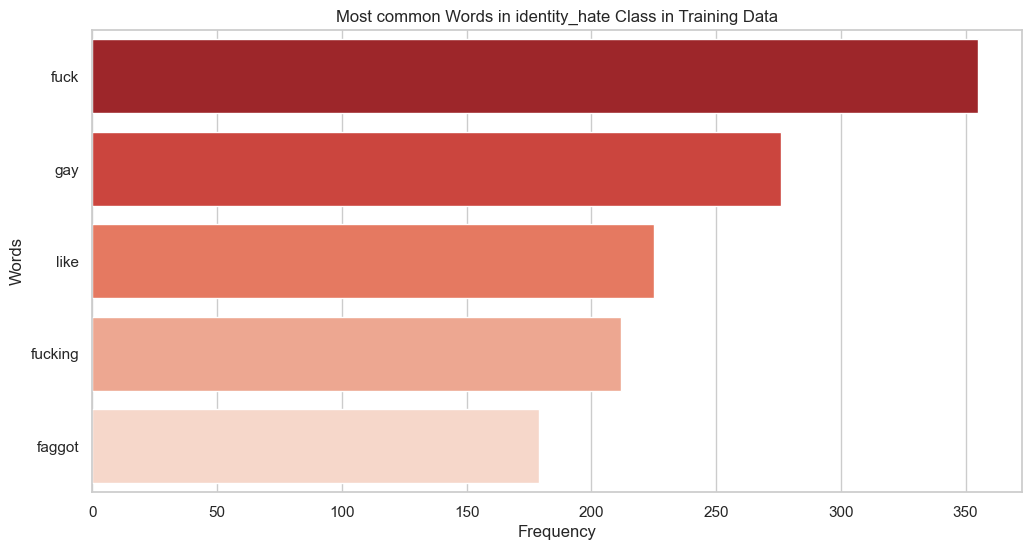

Most common words in identity_hate class: [('fuck', 355), ('gay', 276), ('like', 225), ('fucking', 212), ('faggot', 179)]


In [128]:
def plot_common_words(counts, title):
    labels = [word for word, _ in counts]
    freqs = [count for _, count in counts]

    # Use seaborn for a more visually appealing plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=freqs, y=labels, palette="Reds_r")  
    
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.show()

# Visualise the 5 most common words for each class distribution
for label in class_labels:
    words = []
    for comment in df_train[df_train[label] == 1]['comment_text']:
        words.extend(comment)
    
    most_common_words = Counter(words).most_common(5)
    plot_common_words(most_common_words, f'Most common Words in {label} Class in Training Data')
    print(f'Most common words in {label} class: {most_common_words}')
    warnings.filterwarnings(action = 'ignore')


### Exploring Class Distribution and Imbalance 

In [129]:
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for column in class_columns:
    class_counts = df[column].value_counts()
    
    print(f"{column.capitalize()} Counts:")
    for index, count in class_counts.items():
        class_label = "Non-" + column if index == 0 else column
        print(f"{class_label}: {count}")
    
    print()

Toxic Counts:
Non-toxic: 144277
toxic: 15294

Severe_toxic Counts:
Non-severe_toxic: 157976
severe_toxic: 1595

Obscene Counts:
Non-obscene: 151122
obscene: 8449

Threat Counts:
Non-threat: 159093
threat: 478

Insult Counts:
Non-insult: 151694
insult: 7877

Identity_hate Counts:
Non-identity_hate: 158166
identity_hate: 1405



### Task 1 Summary

Based on the output of category_counts and category_counts_test above, we can see that the data is highly imbalanced.

While data augmentation techniques can be used to balance the data, we will use class weights to balance the data during training.

Class weights are calculated as the inverse of the class frequency in the training data, per sci-kit learn documentation:

Formula: n_samples / (n_classes * np.bincount(y))

Due to the highly imbalanced nature of this dataset, accuracy might not be a good metric for evaluation. Precision, Recall or AUC would be more suitable.

To be consistent with the evaluation metric of the competition, we will use ROC-AUC as the evaluation metric for our models.

---
## Section 3. Feature Extraction

### TF-IDF Implementation

TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [130]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=None, tokenizer=lambda x: x, preprocessor=lambda x: x)

# Fit and transform the training and test data
x = vectorizer.fit_transform(df_train['comment_text'])
x_test = vectorizer.transform(df_test['comment_text'])

# Extract labels
y = df_train[class_labels]
y_test = df_test[class_labels]

# Save vectorizer
with open('model/tfidf-vectorizer.dill', 'wb') as f:
    dill.dump(vectorizer, f)

Saving the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is a common practice in machine learning workflows. Here's why you might want to save the TF-IDF vectorizer:

Consistent Feature Representation:

By saving the TF-IDF vectorizer, you ensure consistency in the feature representation of your data. When deploying a machine learning model, you'll often want to use the same vectorizer that was used during training to transform the input data into the format expected by the model.
Scalability:

If your model is trained on a large dataset and the TF-IDF vectorizer is computationally expensive to fit, saving it allows you to avoid re-computing the vectorizer when deploying the model. This can be particularly useful in production scenarios.
Reproducibility:

Saving the vectorizer ensures that you can reproduce the same feature transformations in the future. This is essential for model interpretability, debugging, and for sharing your work with others.

## Section 4. Machine Learning Model Development

In [131]:
def evaluate_classifier(clf, X_test, y_test, class_labels, model_name):
    """
    Evaluate classifier performance.

    Parameters:
    - clf: Classifier object
    - X_test: Features for testing
    - y_test: True labels for testing
    - class_labels: List of strings, class labels
    - model_name: String, name of the model

    Returns:
    - dict: Performance metrics
    - str: Classification report
    - array: Confusion matrix
    """
    # Predictions
    y_pred = clf.predict(X_test)

    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
    auc_roc = roc_auc_score(np.array(y_test), y_pred, average='micro')

    # Performance report
    performance_metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

    # Confusion matrix
    conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_labels, zero_division=1)

    return performance_metrics, class_report, conf_matrix

def plot_multilabel_confusion_matrix(clf, X_test, y_test, class_labels, model_name):
    """
    Plot multilabel confusion matrix.

    Parameters:
    - clf: Classifier object
    - X_test: Features for testing
    - y_test: True labels for testing
    - class_labels: List of strings, class labels
    - model_name: String, name of the model

    Returns:
    - None
    """
    # Plot confusion matrix
    disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=class_labels, cmap='Blues', xticks_rotation='vertical')
    disp.ax_.set_title(f'Multilabel Confusion Matrix ({model_name})')

    plt.show()

In [132]:
# Create classifier instances
lr = LogisticRegression(max_iter=1000)
nb = MultinomialNB()
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)

**Logistic Regression:**

Advantages:
Interpretability: Logistic Regression is a simple and interpretable model, making it easy to understand the impact of individual features on the prediction.
Efficiency: It performs well with a large number of features, making it suitable for NLP tasks where text data is often high-dimensional.

Applicability to NLP: Logistic Regression is a natural fit for binary classification tasks, such as hate speech detection, where the goal is to classify text into categories like hate speech or non-hate speech. It works well with TF-IDF features or word embeddings.


**Multinomial Naive Bayes:**

Advantages:
Efficiency: Naive Bayes is computationally efficient and fast, making it suitable for large datasets.
Works well with text data: It assumes that features are conditionally independent given the class, which simplifies calculations and often works well with text data.

Applicability to NLP: Multinomial Naive Bayes is commonly used in text classification tasks, including hate speech detection. It's particularly effective when dealing with word frequency representations like TF-IDF.

**MLPClassifier (Neural Network):**

Advantages:
Non-linearity: Neural networks, including MLP (Multi-Layer Perceptron), can capture complex non-linear relationships in data, allowing for better representation learning.

Flexibility: Neural networks can be adapted to various architectures, making them suitable for diverse NLP tasks.

Applicability to NLP: MLPClassifier, being a type of neural network, can capture intricate patterns and relationships in text data. It's particularly useful when dealing with deep learning approaches for NLP tasks, offering high flexibility and adaptability.

In [133]:
# Initialize the classifiers
lr = LogisticRegression(class_weight='balanced', random_state=0)
nb = MultinomialNB()
mlp = MLPClassifier()

# Train and test models
init_classifiers = {'LogisticRegression': lr_pipe, 'MultinomialNB': nb_pipe, 'MLPClassifier': mlp_pipe}
classifiers = {}

metrics = []
class_reports = {}
conf_matrices = {}

for key, classifier in init_classifiers.items():
    classifiers[key] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    out_dict, class_report, conf_matrix = eval_clf(classifiers[key], X_test, y_test, class_labels, key)
    metrics.append(out_dict)
    class_reports[key] = class_report
    conf_matrices[key] = conf_matrix

python(35917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


AttributeError: 'csr_matrix' object has no attribute 'lower'

## Section 5. Model Evaluation